**Aperture Photometry Learning Notebook**

**Author:** Rui Zhu

**Creation date:** 2023-04-02

**Update time:** --

**cite from:** https://photutils.readthedocs.io/en/stable/aperture.html

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# [1. Creating Aperture Objects](https://photutils.readthedocs.io/en/stable/aperture.html#creating-aperture-objects)

In [2]:
# Example: creating circular apertures in pixel

from photutils.aperture import CircularAperture
# define two circular apertures located at pixel coordinates (30, 30) and (40, 40)
# with a ridius of 3 pixels
positions = [(30, 30), (40, 40)]
aperture = CircularAperture(positions, r=3.0)

In [3]:
# Example: creating aperture objects in sky coordinates

# Note: 通过SkyCoord定义的孔径在仅仅定义了Sky上的孔径形状，在之后的测光之前，还是会根据WCS
# 转换为像素位置，这时就有可能会发生形状改变。因此，最好直接使用像素来定义孔径。

from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
positions = SkyCoord(l=[1.2, 2.3] * u.deg, 
                     b=[0.1, 0.2] * u.deg, 
                     frame='galactic')
aperture = SkyCircularAperture(positions, r=4.0 * u.arcsec)

In [4]:
# Converting between pixel and sky apertures

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from photutils.aperture import CircularAperture

# get the wcs from data
f = get_pkg_data_filename('data/j94f05bgq_flt.fits', package='astropy.wcs.tests')
hdul = fits.open(f)
wcs = WCS(hdul[1].header)

# convert pixel aperture to sky aperture
aperture = CircularAperture(positions=(10, 20), r=4.0)
sky_aperture = aperture.to_sky(wcs)

print(aperture)
print(sky_aperture)

Aperture: CircularAperture
positions: [10., 20.]
r: 4.0
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (5.5272474, -72.05192188)>
r: 0.1937959570101216 arcsec


# [2. Performing aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html#performing-aperture-photometry)

## 2.1. basic usage

In [5]:
# define the data for test
data = np.ones(shape=(100, 100))

# define the aperture in pixel
positions = [(30, 30), (40, 40)]
aperture = CircularAperture(positions, r=3.0)

# perform aperture photometry
from photutils.aperture import aperture_photometry
phot_tbl = aperture_photometry(data, aperture)

# modified the format of photometrical table
phot_tbl['aperture_sum'].info.format = '%.8g'  # 保留8位有效数字

# show the result
print(phot_tbl)

# Since all the data values are 1, the aperture sums are equal to the area of a 
# corcle with a radius of 3
print(np.pi * 3.0 ** 2)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0    28.274334
  2    40.0    40.0    28.274334
28.274333882308138


## [2.2 Aperture and pixel overlap](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-and-pixel-overlap)
* 孔径的几何形状不能精细由像素表示，因此，`aperture_photometry`函数提供了提供了`method`参数来指定不同的精确采样的方法
* method参数的3个选项：
    1. 'exact': (默认值) 精确测量孔径和像素交叠的比例，计算的最准，但是最慢
    2. 'center': 只看每个像素的中心是否在孔径内
    3. 'subpixel': 讲每个像素重采样为`subpixel`个子像素, 然后看子像素的中心是否在孔径内

In [6]:
# define the data for test
data = np.ones(shape=(100, 100))

aperture = CircularAperture(positions=(30, 30), r=3.0)

phot_tbl_exact = aperture_photometry(data, aperture, method='exact')
print(phot_tbl_exact['aperture_sum'].value[0], "# 可见这个是超精细的采样, 是最准的结果")

phot_tbl_center = aperture_photometry(data, aperture, method='center')
print(phot_tbl_center['aperture_sum'].value[0])

phot_tbl_subpixel = aperture_photometry(data, aperture, method='subpixel', subpixels=5)
print(phot_tbl_subpixel['aperture_sum'].value[0])

phot_tbl_subpixel = aperture_photometry(data, aperture, method='subpixel', subpixels=5000)
print(phot_tbl_subpixel['aperture_sum'].value[0], "# 提升采样率，结果更加精确, 但计算时间显著增高, exact method有算法的优化")

28.274333882308134 # 可见这个是超精细的采样, 是最准的结果
25.0
27.96
28.27434224 # 提升采样率，结果更加精确, 但计算时间显著增高, exact method有算法的优化


In [7]:
%%timeit
phot_tbl_exact = aperture_photometry(data, aperture, method='exact')

143 µs ± 433 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
phot_tbl_subpixel = aperture_photometry(data, aperture, method='subpixel', subpixels=5)

# exact方法的计算时间跟采样率为5的subpixel方法差不多，但是exact方法的结果更加精确

144 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## [2.3 Aperture photometry with multiple apertures at each position](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-photometry-with-multiple-apertures-at-each-position)
* 以上例子看到, 虽然可以在positons参数里输入多个位置坐标, 但是孔径的大小只能选用固定的值.
* 本节介绍如何处理这种多个目标位置, 多个孔径的情况

In [9]:
# Example: perform aperture photometry with three different apertures on two sources

radii = [3.0, 4.0, 5.0]  # three apertures with different radii
positions = [(30, 30), (40, 40)]  # two sources

# create a list of aperture objects
apertures = [CircularAperture(positions, r=r) for r in radii]
print(apertures)

phot_tbl = aperture_photometry(data, apertures)

# format the table output
for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output

print(phot_tbl)

[<CircularAperture([[30., 30.],
                 [40., 40.]], r=3.0)>, <CircularAperture([[30., 30.],
                 [40., 40.]], r=4.0)>, <CircularAperture([[30., 30.],
                 [40., 40.]], r=5.0)>]
 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1      30      30      28.274334      50.265482      78.539816
  2      40      40      28.274334      50.265482      78.539816


In [10]:
# Example: elliptical aperture
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture

# define two elliptical apertures located at pixel coordinates (30, 30) and (40, 40)
positions = [(30, 30), (40, 40)]
a = 5.0
b = 3.0
theta = Angle(45.0, unit='deg')
apertures = EllipticalAperture(positions, a, b, theta=theta)
print(apertures)

phot_tbl = aperture_photometry(data, apertures)

for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output

print("\n----- result -----")
print(phot_tbl)

Aperture: EllipticalAperture
positions: [[30., 30.],
            [40., 40.]]
a: 5.0
b: 3.0
theta: 45.0 deg

----- result -----
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1      30      30     47.12389
  2      40      40     47.12389


In [11]:
# Example: multiple apertures

a = [5, 6, 7]
b = [3, 4, 5]
theta = Angle([45, 60, 75], unit='deg')
positions = [(30, 30), (40, 40)]

# create 3 elliptical apertures for 2 positions
apertures = [EllipticalAperture(positions, ai, bi, theta=thetai) for (ai, bi, thetai) in zip(a, b, theta)]
print(apertures)

phot_tbl = aperture_photometry(data, apertures)

for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output

print("\n----- result -----")
print(phot_tbl)

[<EllipticalAperture([[30., 30.],
                   [40., 40.]], a=5.0, b=3.0, theta=45.0 deg)>, <EllipticalAperture([[30., 30.],
                   [40., 40.]], a=6.0, b=4.0, theta=60.0 deg)>, <EllipticalAperture([[30., 30.],
                   [40., 40.]], a=7.0, b=5.0, theta=75.0 deg)>]

----- result -----
 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1      30      30       47.12389      75.398224      109.95574
  2      40      40       47.12389      75.398224      109.95574


## [2.4 Aperture statistics](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-statistics)

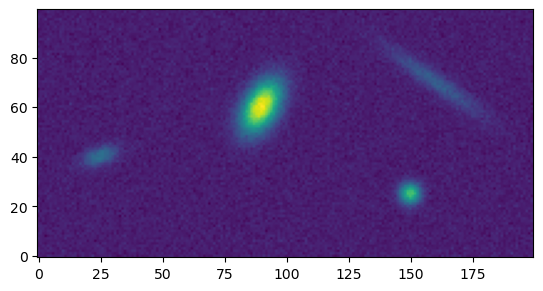

In [12]:
from astropy.stats import sigma_clipped_stats
from photutils.aperture import ApertureStats, CircularAperture
from photutils.datasets import make_4gaussians_image

# test data
data = make_4gaussians_image()
plt.imshow(data, origin='lower');

mean: 5.50, median: 5.41, std: 5.25


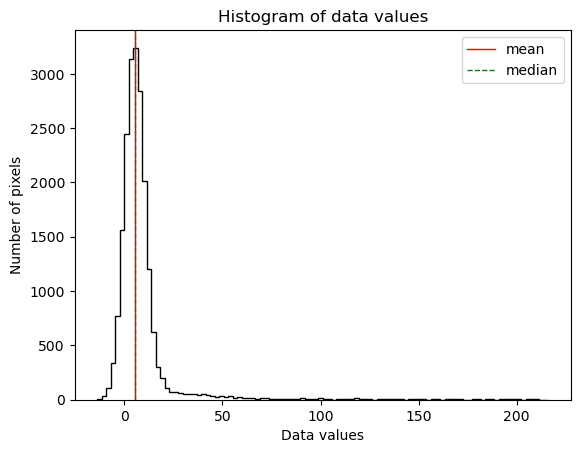

In [13]:
# calculate the background using sigma-clipped statistics
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(f"mean: {mean:.2f}, median: {median:.2f}, std: {std:.2f}")

plt.hist(data.flatten(), bins=100, histtype='step', color='k');
plt.axvline(mean, color='r', linestyle='-', linewidth=1, label='mean')
plt.axvline(median, color='g', linestyle='dashed', linewidth=1, label='median')
plt.title('Histogram of data values');
plt.xlabel('Data values')
plt.ylabel('Number of pixels')
plt.legend();

In [14]:
# calculate the aperture statistics based on the background-subtracted data
data = data - median
aper = CircularAperture(positions=(150, 25), r=8)
aper_stats = ApertureStats(data, aper)

# all properties calculated are saved in the ApertureStats object
# see https://photutils.readthedocs.io/en/stable/api/photutils.aperture.ApertureStats.html#photutils.aperture.ApertureStats
print(aper_stats.xcentroid, aper_stats.ycentroid)
print(aper_stats.fwhm)
print(aper_stats.ellipticity)
print(aper_stats.orientation)

149.98572304129868 24.996938431105146
6.6072346551783125 pix
0.006002275803447588
33.990853834827206 deg


In [15]:
aper_stats.to_table()

id,xcentroid,ycentroid,sky_centroid,sum,sum_err,sum_aper_area,center_aper_area,min,max,mean,median,mode,std,mad_std,var,biweight_location,biweight_midvariance,fwhm,semimajor_sigma,semiminor_sigma,orientation,eccentricity
,,,,,,pix2,pix2,,,,,,,,,,,pix,pix,pix,deg,
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,149.98572304129868,24.996938431105146,None,8030.736512250234,nan,201.0619298297468,193.0,-2.260288346228804,144.2467597885593,41.45359513219223,28.335251716057705,2.0985648837886544,38.25291812758177,29.11916067805895,1463.285745275474,30.170013395153592,1294.3219021706839,6.6072346551783125,2.8142675090835665,2.7973754993093656,33.990853834827206,0.10940075087527741


In [16]:
# Example: aperture statistics for multiple objects
aper = CircularAperture(positions=[(150, 25), (90, 60)], r=10)
aper_stats = ApertureStats(data, aper)

stats_tbl = aper_stats.to_table()
stats_tbl  # each row corresponds to one aperture

id,xcentroid,ycentroid,sky_centroid,sum,sum_err,sum_aper_area,center_aper_area,min,max,mean,median,mode,std,mad_std,var,biweight_location,biweight_midvariance,fwhm,semimajor_sigma,semiminor_sigma,orientation,eccentricity
,,,,,,pix2,pix2,,,,,,,,,,,pix,pix,pix,deg,
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,149.96671383819248,24.97364514345597,None,8164.510107085804,nan,314.1592653589793,305.0,-13.920996924036256,144.2467597885593,26.792685369953865,11.134969848247437,-20.18046119516542,36.189317624748654,16.092832634549136,1309.6667101449436,10.685331513172896,416.10722576224845,6.826692736841311,2.923525278620953,2.8743249342449073,67.50450598505329,0.18268829117812072
2,90.00873475137381,59.98514318956604,None,34930.47721038951,nan,314.1592653589793,305.0,16.773194133872764,210.6363699478464,113.09856218816154,111.77053744417351,109.11448795619748,50.10054012959997,59.83291659630864,2510.0641212776573,112.4670616346628,2728.765933641855,10.251297734003893,4.791537265485658,3.8657539207232907,58.846230107419125,0.5908412715450284


# [3. local bkg subtraction](https://photutils.readthedocs.io/en/stable/aperture.html#local-background-subtraction)
* 全局的背景估计使用`Background2D函数`
* 这里介绍局域背景估计的方法: 选取孔径环, 平均或sigma-clip计算像素背景, 然后乘上孔径面积, 作为孔径内的总背景

In [17]:
from photutils.datasets import make_100gaussians_image

# test data
data = make_100gaussians_image()
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(f"mean: {mean:.2f}, median: {median:.2f}, std: {std:.2f}")
# ! 简单的看下背景, 就发现, 这个测试图像有一个背景值为5左右

mean: 5.20, median: 5.16, std: 2.09


In [18]:
# perform the photometry for three sources in a circular aperture with a radius 
# of 5 pixels and estimate the local background using a circular annulus of inner
# radius 10 pixels and outer radius 15 pixels

from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus

positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
apertures = CircularAperture(positions, r=5.)
annulus_aperture = CircularAnnulus(positions, r_in=10., r_out=15.)

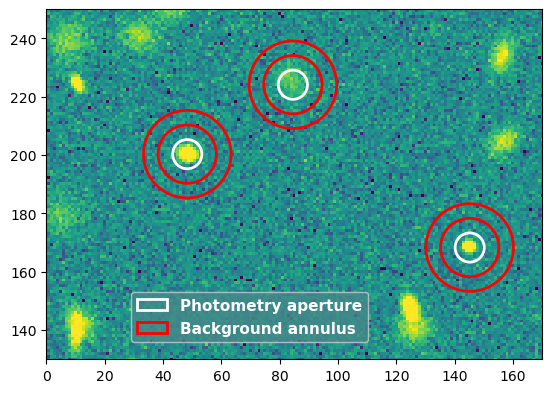

In [19]:
# show the aperture and annulus

from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest')
plt.xlim(0, 170)
plt.ylim(130, 250)

# aperture自带的方法, 用来画出aperture的位置
ap_patches = apertures.plot(color='white', lw=2, 
                            label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11});

## [3.1 simple mean for bkg estimation](https://photutils.readthedocs.io/en/stable/aperture.html#simple-mean-within-a-circular-annulus)
**用孔径环的背景均值计算孔径内的total bkg**
* step1: 计算背景环孔径内背景的平均值
* step2: 计算未扣除背景的孔径测光对每个源
* step3: 计算孔径内的total bkg
* step4: 背景扣除

In [20]:
# compute the mean bkg level within the annulus at each position
from photutils.aperture import ApertureStats
aperstats = ApertureStats(data, annulus_aperture)
bkg_mean = aperstats.mean
print(bkg_mean)  # mean local per-pixel background level
# ! 可见局域背景值和全局背景差不多

[4.96369499 5.10467691 4.9497741 ]


In [21]:
# perform the photometry for each aperture
from photutils.aperture import aperture_photometry

phot_tbl = aperture_photometry(data, apertures)

for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output
print(phot_tbl)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   145.1   168.3    1131.5794
  2    84.5   224.1    746.16064
  3    48.3   200.3    1250.2186


In [22]:
# compute the area of the circular aperture
aper_area = apertures.area_overlap(data)
print(aper_area)

# compute the total bkg within the circular aperture
total_bkg = bkg_mean * aper_area
print(total_bkg)

# compute the bkg-subtracted photometry
phot_bkgsub = phot_tbl['aperture_sum'] - total_bkg

[78.53981633974485, 78.53981633974482, 78.53981633974483]
[389.84769319 400.92038721 388.75434843]


In [23]:
# add the bkg-subtracted photometry to the table
phot_tbl['total_bkg'] = total_bkg
phot_tbl['aperture_sum_bkgsub'] = phot_bkgsub

for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output
print(phot_tbl)

 id xcenter ycenter aperture_sum total_bkg aperture_sum_bkgsub
      pix     pix                                             
--- ------- ------- ------------ --------- -------------------
  1   145.1   168.3    1131.5794 389.84769           741.73173
  2    84.5   224.1    746.16064 400.92039           345.24026
  3    48.3   200.3    1250.2186 388.75435           861.46422


## [3.2 sigma-clipped median for bkg estimation](https://photutils.readthedocs.io/en/stable/aperture.html#sigma-clipped-median-within-a-circular-annulus)
**在孔径环内做sigma-clipped计算背景**

In [24]:
from astropy.stats import SigmaClip

sigclip = SigmaClip(sigma=3., maxiters=10)

# 不扣除背景的孔径统计
aper_stats = ApertureStats(data, apertures)

# 孔径环内的背景统计
bkg_stats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
print(bkg_stats.median)

[4.848213   5.0884354  4.80605993]


In [25]:
# 这时又有两种选择
# 方案1: 跟上面一样, 未扣除背景的孔径测光-孔径内的总背景
total_bkg = bkg_stats.median * aper_stats.sum_aper_area.value
print(total_bkg)

apersum_bkgsub = aper_stats.sum - total_bkg
print(apersum_bkgsub)

# 方案2: 将孔径内的背景统计传入孔径统计中, 直接返回扣除背景的孔径统计
aper_stats_bkgsub = ApertureStats(data, apertures, local_bkg=bkg_stats.median)
print(aper_stats_bkgsub.sum)
# ! 可见这两种方案结果是一模一样的

[380.77775843 399.64478152 377.46706442]
[750.80166351 346.51586233 872.75150158]
[750.80166351 346.51586233 872.75150158]


# [4. Aperture photometry error estimation](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-photometry-error-estimation)
* 只有传入error image才能计算孔径测光误差

In [26]:
positions = [(30, 30), (40, 40)]
aperture = CircularAperture(positions, r=3)
data = np.ones((100, 100))
error = 0.1 * data

phot_tbl = aperture_photometry(data, aperture, error=error)

for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output
print(phot_tbl)

 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1      30      30    28.274334       0.53173616
  2      40      40    28.274334       0.53173616


**使用calc_total_error函数计算误差图**
* 上面计算的误差传入的error image是total error, 包含互不相关的每个源独立的Poisson noise
* 而经常我们只有平滑后只有背景误差的error image, 需要使用`calc_total_error()`函数计算包含每个源的Poisson noise的误差图
* 如果像素值的单位是e/s, 则使用曝光时间作为有效增益

In [27]:
from photutils.utils import calc_total_error
effective_gain = 500 # seconds
bkg_error = 0.1 * data
error = calc_total_error(data, bkg_error, effective_gain)

# the data should be background-subtracted
phot_tbl = aperture_photometry(data, aperture, error=error)

for col in phot_tbl.colnames:
    phot_tbl[col].info.format = '%.8g'  # for consistent table output
print(phot_tbl)

 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1      30      30    28.274334       0.58248777
  2      40      40    28.274334       0.58248777


# [5. Aperture photometry with pixel masking](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-photometry-with-pixel-masking)

In [28]:
data = np.ones((5, 5))
aperture = CircularAperture(positions=(2, 2), r=2)

# create the mask image
mask = np.zeros(data.shape, dtype=bool)
data[2, 2] = 100  # a bad pixel
mask[2, 2] = True

phot_tbl = aperture_photometry(data, aperture, mask=mask)
phot_tbl_nomask = aperture_photometry(data, aperture)

print(phot_tbl)
print(phot_tbl_nomask)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1     2.0     2.0 11.566370614359172
 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1     2.0     2.0 111.56637061435917


# [6. Aperture photometry using sky coordinates](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-photometry-using-sky-coordinates)

In [33]:
import astropy.units as u
from astropy.wcs import WCS

path_img = "./material/spitzer_example_image.fits"
path_cat = "./material/spitzer_example_catalog.xml"

hdu = fits.open(path_img)[0]
data = u.Quantity(hdu.data, unit=hdu.header['BUNIT'])
wcs = WCS(hdu.header)

from astropy.table import Table
catalog = Table.read(path_cat, format='votable')

In [38]:
# define the apertures positions based on the existing catalog positions
positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')
aperture = SkyCircularAperture(positions, r=4.8 * u.arcsec)

In [53]:
phot_tbl = aperture_photometry(data, aperture, wcs=wcs)

# 单位转换
# 像素值的单位
print("original image unit:", hdu.header['BUNIT'])

pixscale = (1.2 * u.arcsec)**2 / u.pixel  # 线尺度时1.2角秒每像素，转换为1.2^2平方角秒每像素
converted_aperture_sum = phot_tbl['aperture_sum'] * pixscale * u.pixel
converted_aperture_sum = converted_aperture_sum.to(u.mJy)
print("converted image unit:", converted_aperture_sum.unit)

original image unit: MJy/sr
converted image unit: mJy


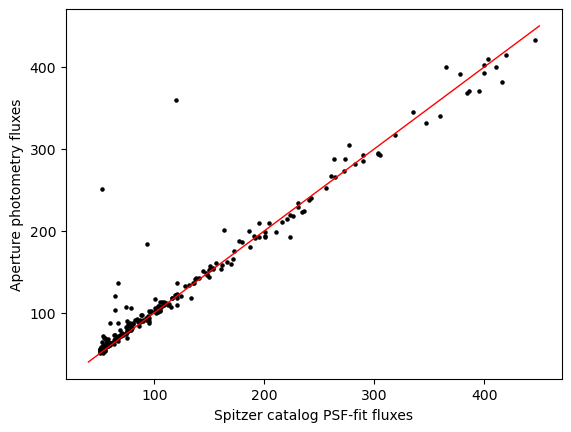

In [56]:
# compare the results with the catalog values
f_catalog = catalog['f4_5']

plt.scatter(f_catalog, converted_aperture_sum, s=5, c='k')
plt.xlabel('Spitzer catalog PSF-fit fluxes')
plt.ylabel('Aperture photometry fluxes')
plt.plot([40, 100, 450], [40, 100, 450], color='r', lw=1);

# [7. Aperture Masks](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-masks)

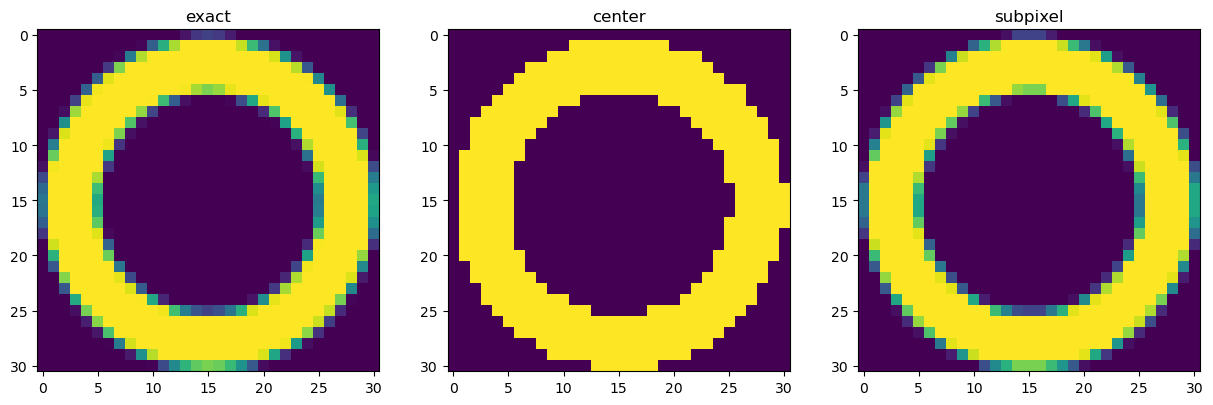

In [73]:
from photutils.aperture import CircularAnnulus
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAnnulus(positions, r_in=10, r_out=15)

masks_exact = aperture.to_mask(method='exact')
masks_center = aperture.to_mask(method='center')
masks_subpixel = aperture.to_mask(method='subpixel', subpixels=5)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
idx = 0
axs[0].imshow(masks_exact[idx])
axs[0].set_title('exact')
axs[1].imshow(masks_center[idx])
axs[1].set_title('center')
axs[2].imshow(masks_subpixel[idx])
axs[2].set_title('subpixel');

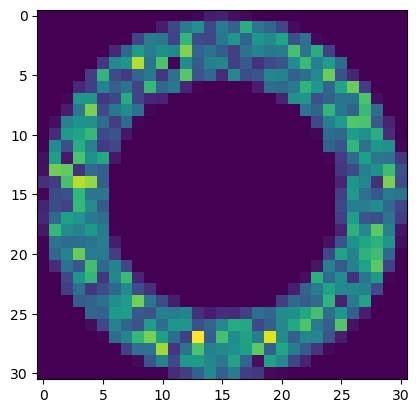

In [77]:
# 画mask孔径乘数据的图，即看看孔径环内的数据
data_weighted = masks_exact[0].multiply(data)
plt.imshow(data_weighted);

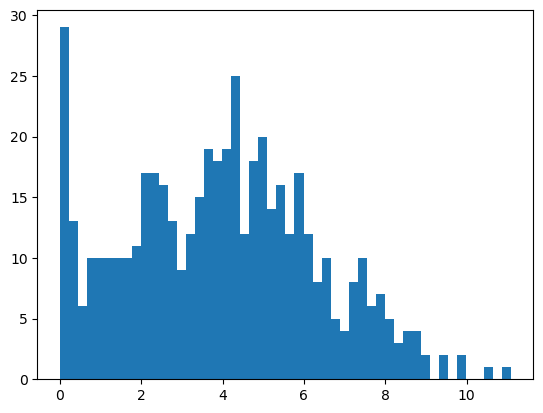

In [81]:
# 使用get_values()方法，将mask孔径内数据转换为一维数组
data_weighted_1d = masks_exact[0].get_values(data)
plt.hist(data_weighted_1d, bins=50);